In [6]:
import os
import warnings
import time
# обработка данных
import pandas as pd
import numpy as np
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
# визуализация данных
import matplotlib.pyplot as plt
from tqdm import tqdm
# классические популярные модели регрессии
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
# метрики точности моделей
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

warnings.filterwarnings("ignore")

In [2]:
%%time
path = 'F:\\Output Datasets\\'
paths = os.listdir(path=path)
datasets = {file[-5:-6:-1]: pd.read_csv(path + file) for file in paths}
apr_days, may_days, dec_days, jan_days = [29, 30], [1, 6, 7, 8, 9], [29, 30, 31], [1, 2, 3, 4, 5, 6, 7, 8]
april, may, december, january = 4, 5, 12, 1
for dataset in datasets:
    data = datasets[dataset]
    data['DD'] = pd.to_datetime(data['DD'])
    data.drop(columns=['SSCL1', 'SEG_CLASS_CODE'], inplace=True)
    data['weekend'] = (data['DD'].dt.dayofweek > 4).astype(int) # 1 - выходной / 0 - рабочий
    data['dayOfWeek'] = data['DD'].dt.dayofweek # дни недели
    data['holidays'] = \
    ((data['DD'].dt.day.isin(apr_days)) & (data['DD'].dt.month == april)   | # праздник весны и труда
    (data['DD'].dt.day.isin(may_days)) & (data['DD'].dt.month == may)      | # 9 мая
    (data['DD'].dt.day.isin(dec_days)) & (data['DD'].dt.month == december) |  # предновогодние дни
    (data['DD'].dt.day.isin(jan_days)) & (data['DD'].dt.month == january))    # новогодние дни
    data['holidays'] = data['holidays'].astype(int)
    dd = data['DD'].apply(lambda x: x.value)
    data['DD'] = (dd - dd.mean()) / dd.std()

Wall time: 1min 50s


In [16]:
def train(model: BaseEstimator, dataset: pd.DataFrame, scores: tuple) -> tuple:
    score_train = {}
    score_test = {}
    X, y = dataset.drop(columns=['PASS_BK']), dataset['PASS_BK']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=100)
    start = time.time()
    model = model.fit(X_train, y_train)
    train_time = time.strftime("%H:%M:%S", time.gmtime(round(time.time() - start, 2)))
    y_train_pred = model.predict(X_train)
    start = time.time()
    y_test_pred = model.predict(X_test)
    test_time = time.strftime("%H:%M:%S", time.gmtime(round(time.time() - start, 2)))
    for score in scores:
        score_train[str(score).split()[1]] = round(score(y_train, y_train_pred), 4)
        score_test[str(score).split()[1]] = round(score(y_test, y_test_pred), 4)
    return train_time, score_train, score_test, test_time

def training_graph(models: list,
                   train_times: list, train_scores: dict,
                   test_times: list, test_scores: dict) -> None:
    metrics = tuple(train_scores[0].keys()) # кортеж всех метрик
    plt.style.use("seaborn")
    for i in range(len(train_scores[0])):
        test_score = np.clip([score[metrics[i]] for score in test_scores], 0, 1)
        plt.bar(models, np.clip([score[metrics[i]] for score in train_scores], 0, 1), width=.5,
                  label='train', alpha=.5, color='#78DBE2') # метрики для train
        plt.bar(models, test_score, width=.5, label='test', alpha=.8, color='#2dd29f') # метрики для test
        plt.title(metrics[i], pad=50, fontsize=22, fontname="Times New Roman")
        for j in range(len(models)):
            plt.text(j, 1.1, train_times[j], ha = 'center')
            time_n_acc = f'{test_times[j]}\n{test_scores[j][metrics[i]]}'
            plt.text(j, test_score[j], time_n_acc, ha='center')
        plt.ylim(0, 1.1)
        plt.xticks(models, rotation=15, fontsize=12, fontname="Times New Roman")
        plt.ylabel('Метрика', fontweight='bold', fontsize=18, fontname="Times New Roman")
        plt.legend(fontsize=14, loc='upper left')
        plt.show()

In [7]:
classic_models = (LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(),
                  KNeighborsRegressor(), SVR(max_iter=200), AdaBoostRegressor(), Ridge())
metrics = (mean_absolute_error, r2_score)
# MAE - в среднем отклонение между реальным и предсказанным значениями (меньше - лучше)
# R2 - насколько данные соответсвуют модели (чем ближе к 1.0, тем лучше); > 80% идеал

In [8]:
cycle = tqdm(classic_models)
models, train_times, train_scores, test_times, test_scores = [], [], [], [], []
for model in cycle:
    cycle.set_description(f"Тестирования {str(model)[:-2]}")
    result_training = train(model, datasets['C'], metrics)
    models.append(str(model))
    train_times.append(result_training[0])
    train_scores.append(result_training[1])
    test_scores.append(result_training[2])
    test_times.append(result_training[3])

Тестирования Ridge: 100%|███████████████████████████████████████████████████████████████| 7/7 [11:49<00:00, 101.40s/it]


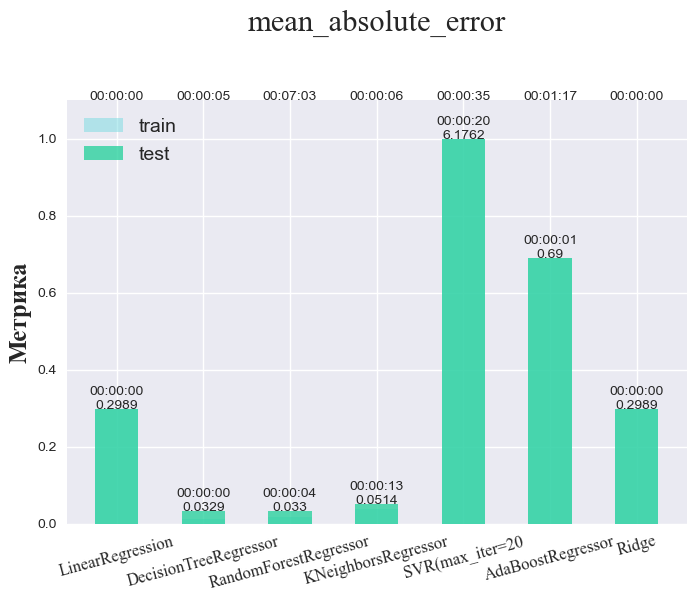

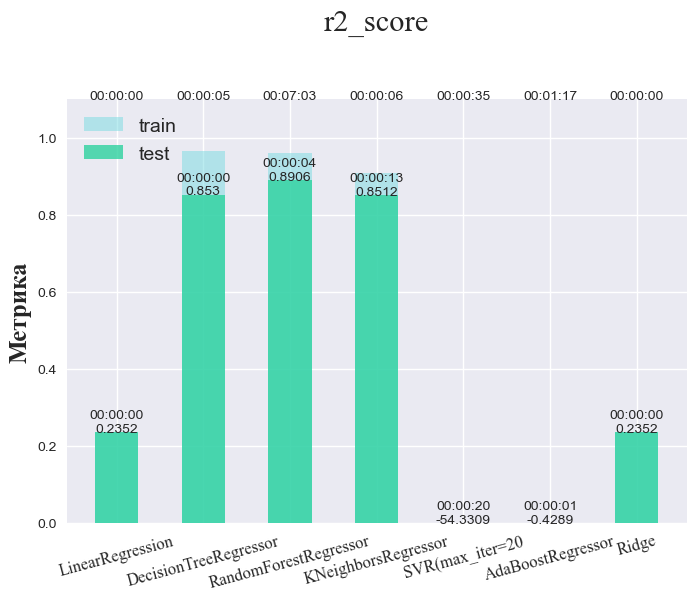

In [17]:
training_graph(models, train_times, train_scores, test_times, test_scores)